In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral208.jpeg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral29.jpeg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral236.jpeg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral81.jpg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral106.jpeg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral107.jpg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral123.jpg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral46.png
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral121.jpg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral290.jpeg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral273.jpg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral20.jpeg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral105.jpg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral113.jpg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral6.jpg
/kaggle/in

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os


2025-07-26 05:55:23.251529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753509323.437405      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753509323.494023      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/vsa-data2/Med/TrainMed/Train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/vsa-data2/Med/TestMed/Test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 899 files belonging to 3 classes.


I0000 00:00:1753509336.421768      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 100 files belonging to 3 classes.
Classes: ['Positive', 'negative', 'neutral']


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


In [7]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=tf.shape(patch)[1], delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [14]:
def create_vit_classifier(
    input_shape=(224, 224, 3),
    patch_size=16,
    projection_dim=64,
    transformer_layers=8,
    num_heads=4,
    mlp_dim=128,
    dropout_rate=0.1,
    num_classes=3,
):
    inputs = layers.Input(shape=input_shape)

    # Calculate number of patches dynamically
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)

    # Create patches
    patches = Patches(patch_size)(inputs)

    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Transformer blocks
    for _ in range(transformer_layers):
        # LayerNorm + MHA + skip
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])

        # LayerNorm + MLP + skip
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(mlp_dim, activation=tf.nn.gelu)(x3)
        x3 = layers.Dropout(dropout_rate)(x3)
        x3 = layers.Dense(projection_dim)(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Classification head
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = layers.Dense(mlp_dim, activation=tf.nn.gelu)(representation)

    logits = layers.Dense(num_classes)(features)

    return keras.Model(inputs=inputs, outputs=logits)


In [15]:
model = create_vit_classifier()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=25
)


Epoch 1/25


I0000 00:00:1753509503.246087     101 service.cc:148] XLA service 0x7f90f00043b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753509503.246984     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753509506.483386     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/29 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4219 - loss: 1.3406  

I0000 00:00:1753509518.277840     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


29/29 ━━━━━━━━━━━━━━━━━━━━ 65s 635ms/step - accuracy: 0.3654 - loss: 1.2580 - val_accuracy: 0.3300 - val_loss: 1.1150
Epoch 2/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3163 - loss: 1.2020 - val_accuracy: 0.2700 - val_loss: 1.1216
Epoch 3/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3858 - loss: 1.1443 - val_accuracy: 0.2700 - val_loss: 1.1284
Epoch 4/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3514 - loss: 1.1294 - val_accuracy: 0.2600 - val_loss: 1.1465
Epoch 5/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4121 - loss: 1.1063 - val_accuracy: 0.2700 - val_loss: 1.1516
Epoch 6/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3940 - loss: 1.0964 - val_accuracy: 0.2600 - val_loss: 1.1552
Epoch 7/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3832 - loss: 1.0992 - val_accuracy: 0.2600 - val_loss: 1.1686
Epoch 8/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4198 - loss: 1.0897 - val_accuracy: 0.2500 - val_loss: 

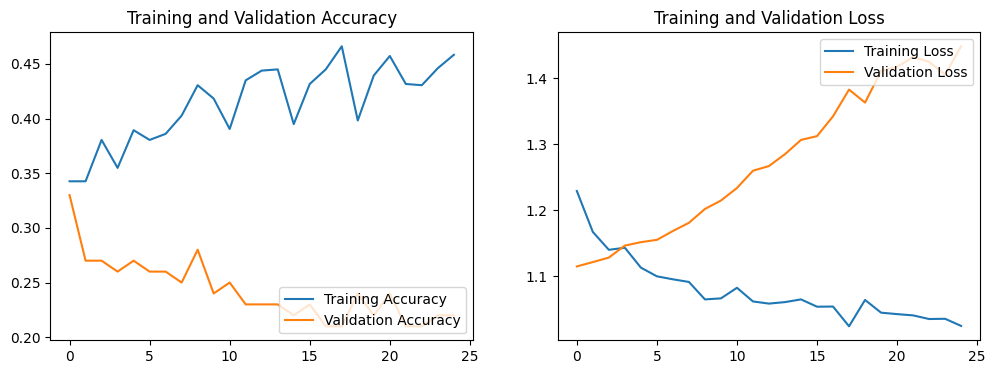

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()


In [17]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")
print(f"🧮 Test Loss: {test_loss:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2526 - loss: 1.4276
✅ Test Accuracy: 22.00%
🧮 Test Loss: 1.4479


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
📊 Classification Report:

              precision    recall  f1-score   support

    Positive       0.18      0.20      0.19        30
    negative       0.00      0.00      0.00        30
     neutral       0.25      0.40      0.30        40

    accuracy                           0.22       100
   macro avg       0.14      0.20      0.17       100
weighted avg       0.15      0.22      0.18       100



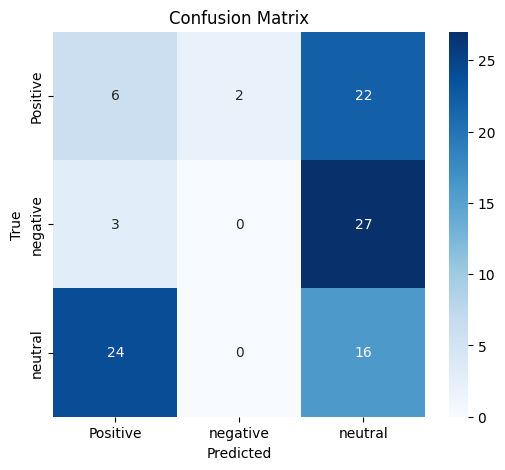

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print("📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


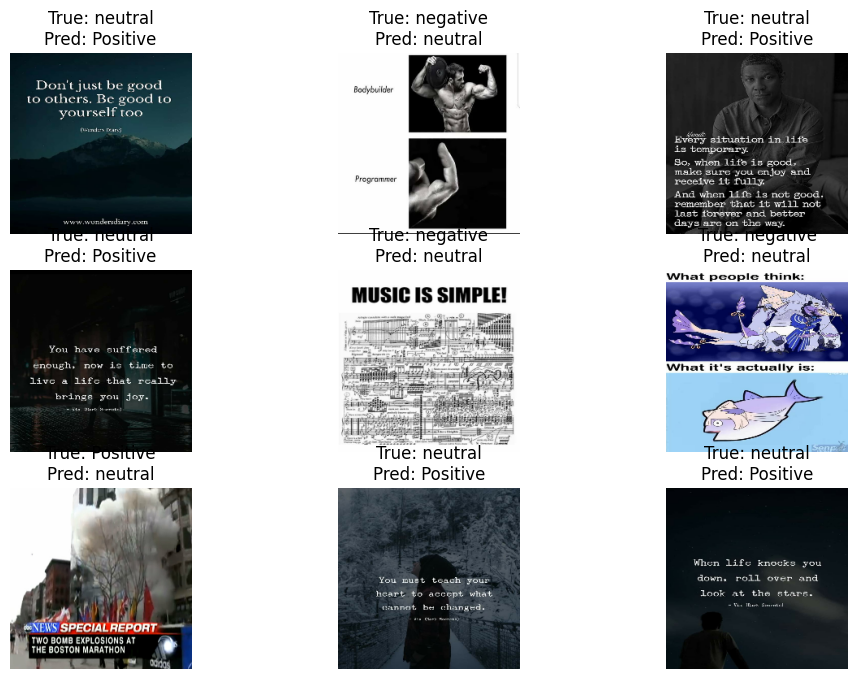

In [19]:
# Show sample predictions
import random

plt.figure(figsize=(12, 8))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i]
        pred = model.predict(tf.expand_dims(img, axis=0))
        predicted_label = class_names[np.argmax(pred)]
        true_label = class_names[labels[i]]
        
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis("off")


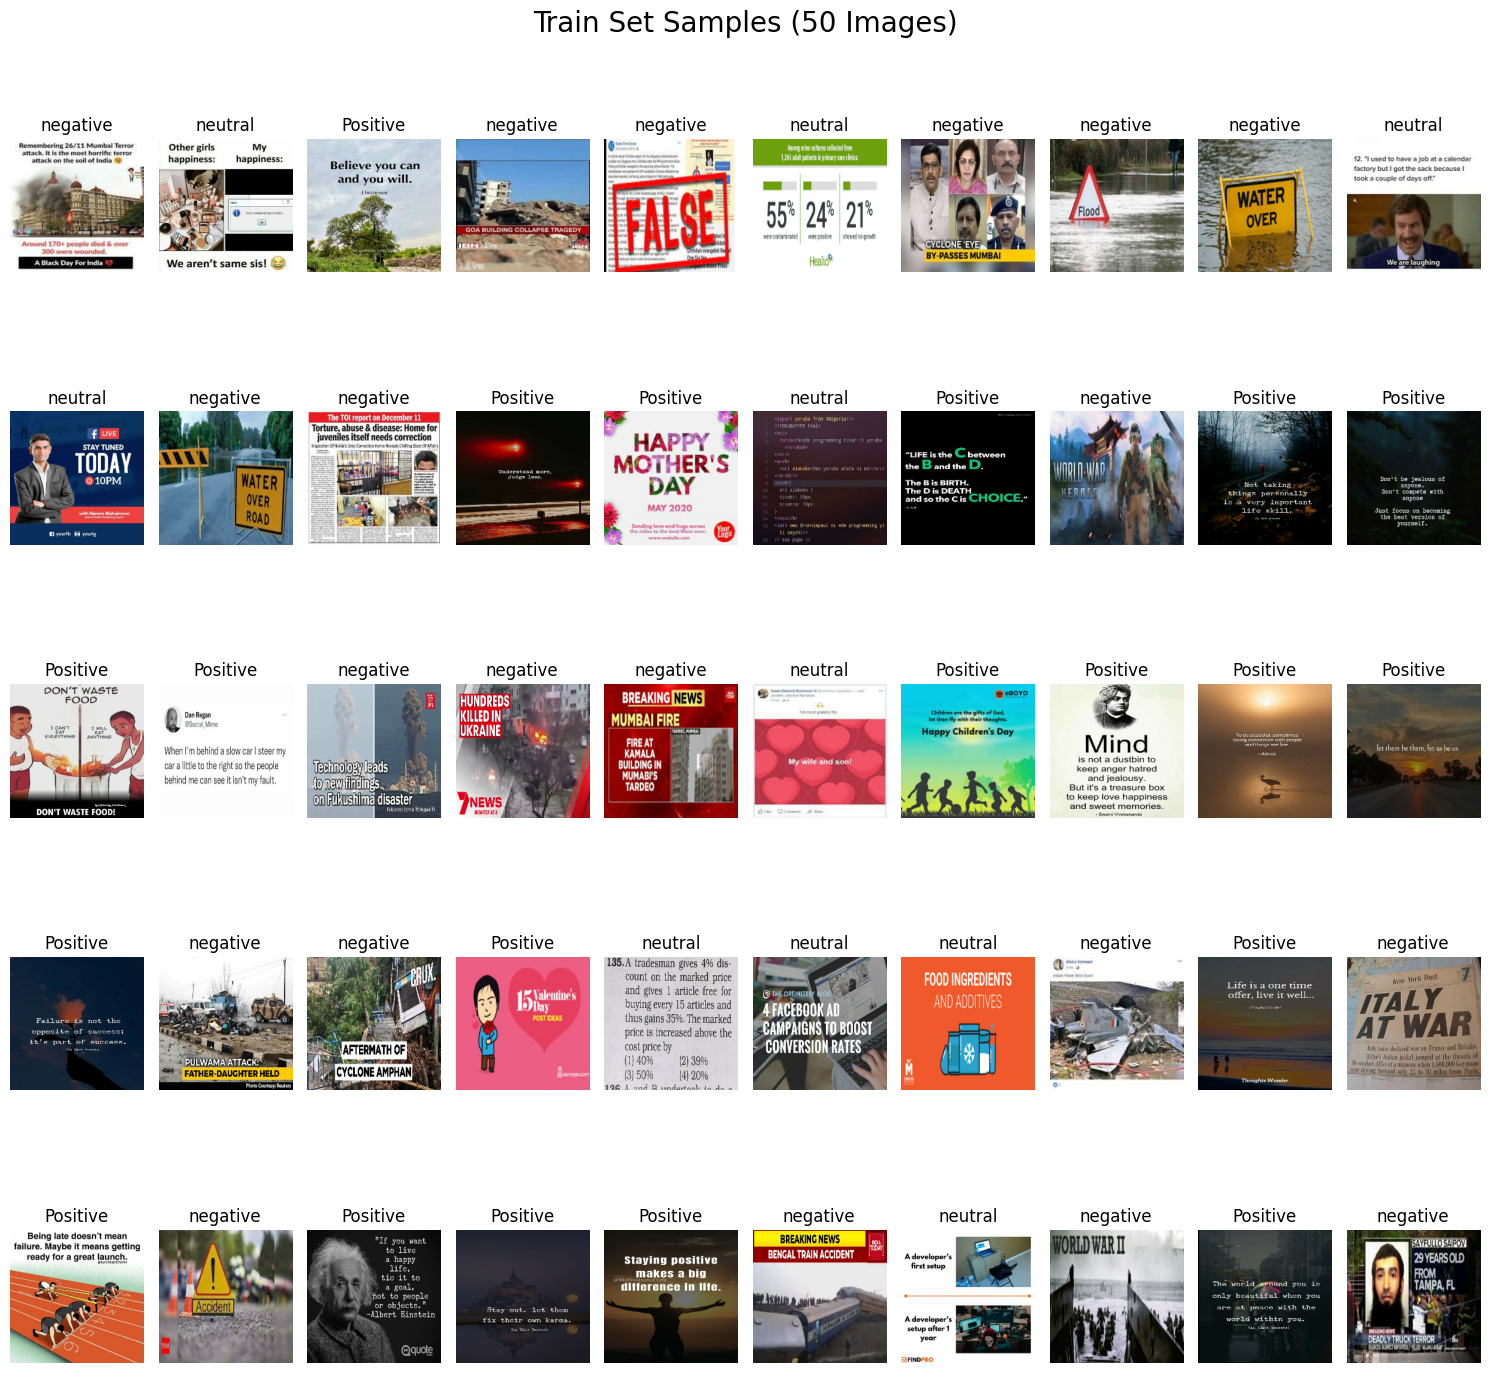

In [20]:
def visualize_dataset(dataset, class_names, title, num_images=50):
    plt.figure(figsize=(15, 15))
    image_count = 0

    for images, labels in dataset.unbatch().take(num_images):
        ax = plt.subplot(5, 10, image_count + 1)
        plt.imshow(images.numpy().astype("uint8"))
        plt.title(f"{class_names[labels]}")
        plt.axis("off")
        image_count += 1

    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

# Visualize 50 images from training set
visualize_dataset(train_ds, class_names, title="Train Set Samples (50 Images)")


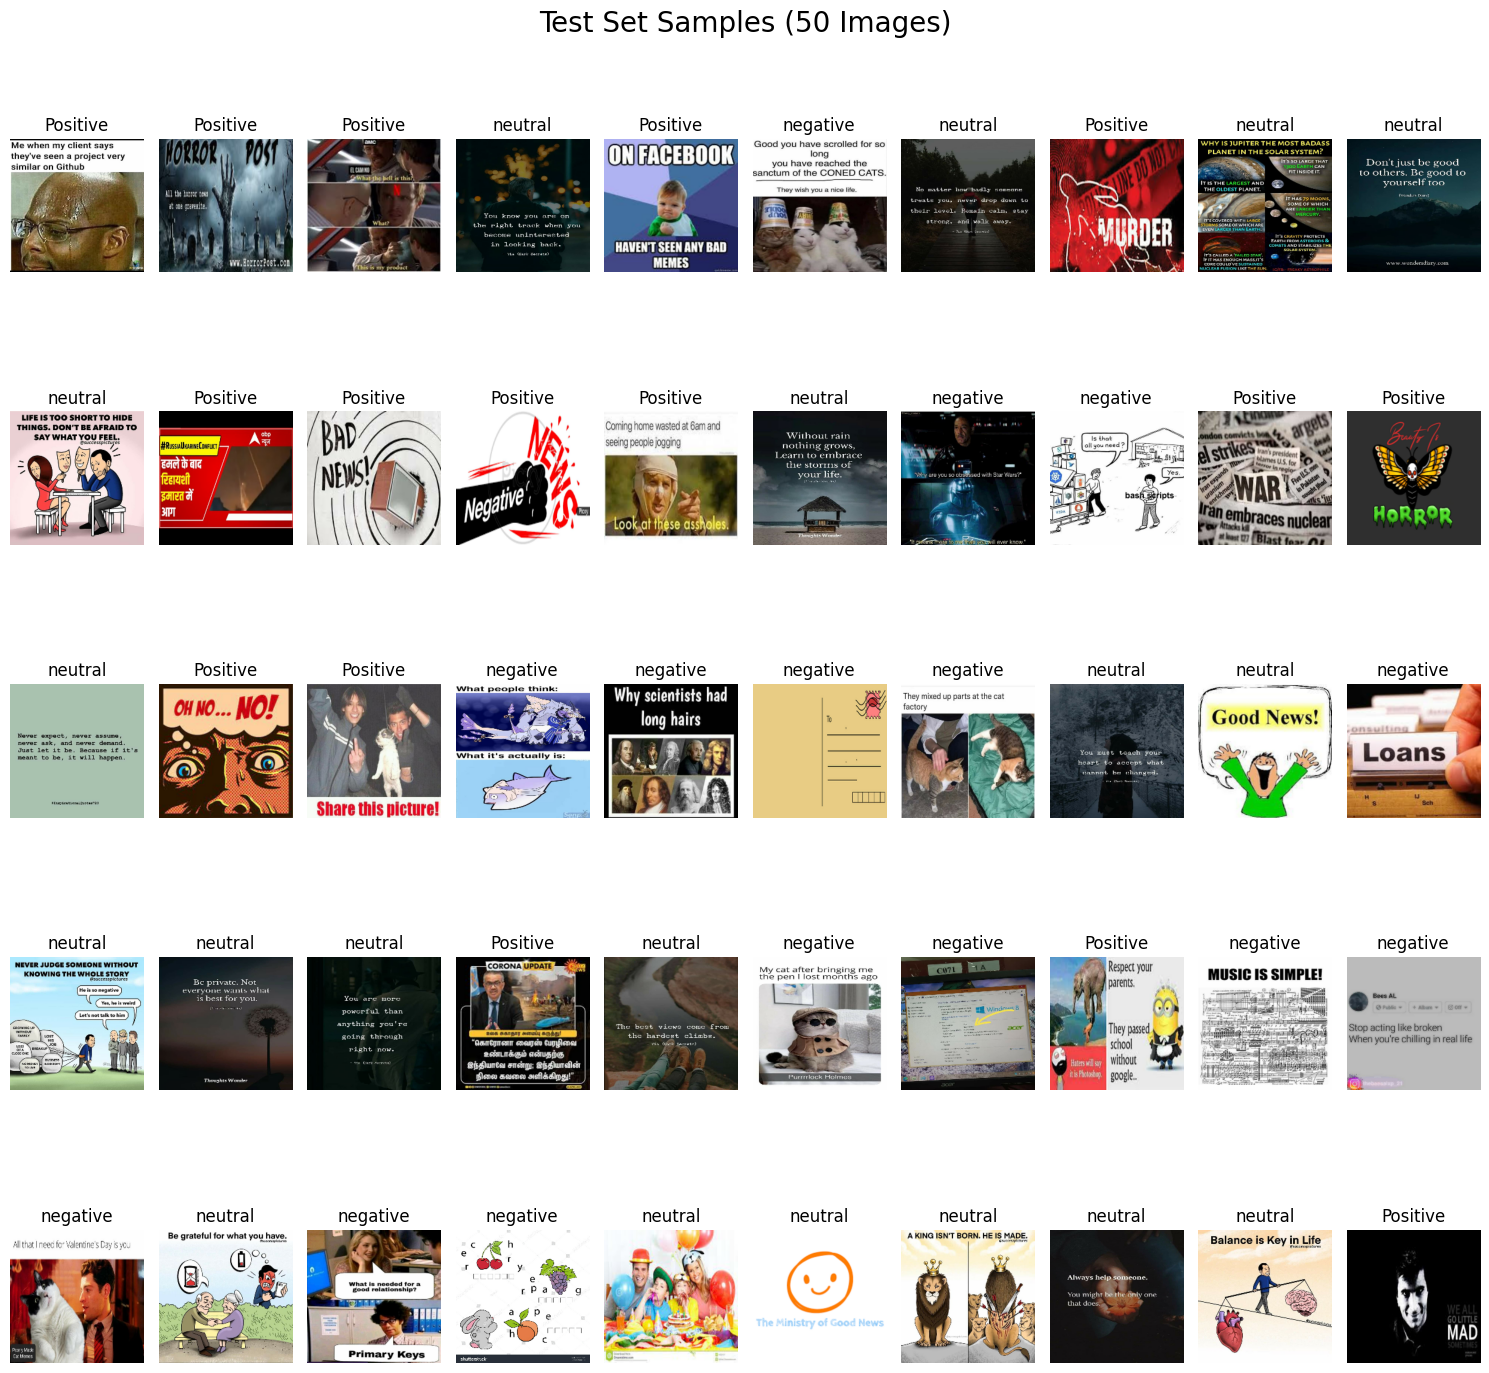

In [21]:
# Visualize 50 images from test set
visualize_dataset(test_ds, class_names, title="Test Set Samples (50 Images)")


In [2]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-mhrigjdz
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-mhrigjdz
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [3]:
import os
import torch
import clip
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Label prompts (CLIP compares image similarity to these)
class_names = ["positive", "negative", "neutral"]
text_prompts = [f"a {label} photo" for label in class_names]
text_tokens = clip.tokenize(text_prompts).to(device)


In [5]:
from glob import glob

def load_images_from_folder(base_path):
    image_paths, labels = [], []
    for label_idx, label in enumerate(class_names):
        folder = os.path.join(base_path, label)
        for img_path in glob(f"{folder}/*"):
            image_paths.append(img_path)
            labels.append(label_idx)
    return image_paths, labels

train_img_paths, train_labels = load_images_from_folder("/kaggle/input/vsa-data2/Med/TrainMed/Train")
test_img_paths, test_labels = load_images_from_folder("/kaggle/input/vsa-data2/Med/TestMed/Test")


In [6]:
def predict_clip(image_paths):
    predictions = []
    for path in tqdm(image_paths):
        try:
            image = preprocess(Image.open(path)).unsqueeze(0).to(device)
            with torch.no_grad():
                image_features = model.encode_image(image)
                image_features /= image_features.norm(dim=-1, keepdim=True)

                text_features = model.encode_text(text_tokens)
                text_features /= text_features.norm(dim=-1, keepdim=True)

                similarities = (100.0 * image_features @ text_features.T)
                pred = similarities.argmax().item()
                predictions.append(pred)
        except:
            predictions.append(-1)  # mark if unreadable
    return predictions


In [7]:
train_preds = predict_clip(train_img_paths)
test_preds = predict_clip(test_img_paths)


100%|██████████| 100/100 [00:03<00:00, 31.64it/s]


In [8]:
from sklearn.metrics import classification_report

print("Test Set Report:\n")
print(classification_report(test_labels, test_preds, target_names=class_names))


Test Set Report:

              precision    recall  f1-score   support

    positive       0.66      0.93      0.77        40
    negative       0.78      0.23      0.36        30
     neutral       0.49      0.57      0.52        30

    accuracy                           0.61       100
   macro avg       0.64      0.58      0.55       100
weighted avg       0.64      0.61      0.57       100



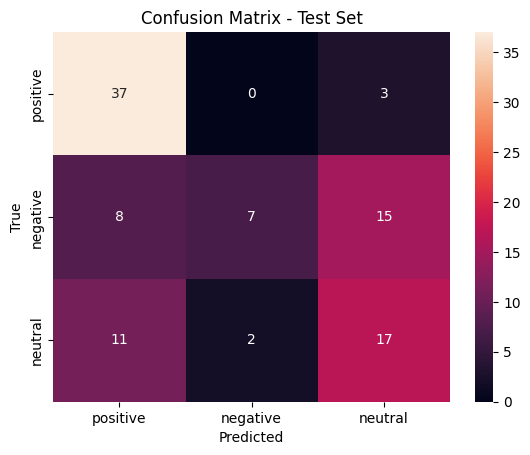

In [9]:
import seaborn as sns
import numpy as np

cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [10]:
import os
import torch
import clip
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Freeze CLIP
for param in model.parameters():
    param.requires_grad = False


In [12]:
class VSADataset(Dataset):
    def __init__(self, root_dir, class_names):
        self.paths = []
        self.labels = []
        self.transform = preprocess
        self.class_names = class_names

        for i, label in enumerate(class_names):
            folder = os.path.join(root_dir, label)
            for img in os.listdir(folder):
                self.paths.append(os.path.join(folder, img))
                self.labels.append(i)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = self.transform(Image.open(self.paths[idx]).convert("RGB"))
        label = self.labels[idx]
        return image, label


In [13]:
class_names = ["Positive", "negative", "neutral"]

train_dataset = VSADataset("/kaggle/input/vsa-data2/Med/TrainMed/Train", class_names)
test_dataset = VSADataset("/kaggle/input/vsa-data2/Med/TestMed/Test", [c.lower() for c in class_names])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [14]:
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes=3):
        super().__init__()
        self.clip_model = clip_model
        self.mlp = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, images):
        with torch.no_grad():
            img_features = self.clip_model.encode_image(images).float()  # 🔧 Cast to float32
        return self.mlp(img_features)


In [15]:
model_mlp = CLIPClassifier(model, num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.mlp.parameters(), lr=1e-4)

epochs = 10
for epoch in range(epochs):
    model_mlp.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model_mlp(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f} - Accuracy: {acc * 100:.2f}%")


100%|██████████| 29/29 [00:12<00:00,  2.28it/s]


Epoch 1/10 - Loss: 29.2031 - Accuracy: 62.63%


100%|██████████| 29/29 [00:10<00:00,  2.67it/s]


Epoch 2/10 - Loss: 24.6732 - Accuracy: 81.54%


100%|██████████| 29/29 [00:10<00:00,  2.71it/s]


Epoch 3/10 - Loss: 20.1807 - Accuracy: 87.21%


100%|██████████| 29/29 [00:10<00:00,  2.68it/s]


Epoch 4/10 - Loss: 16.4825 - Accuracy: 89.54%


100%|██████████| 29/29 [00:10<00:00,  2.69it/s]


Epoch 5/10 - Loss: 13.6034 - Accuracy: 90.55%


100%|██████████| 29/29 [00:10<00:00,  2.64it/s]


Epoch 6/10 - Loss: 11.4799 - Accuracy: 91.77%


100%|██████████| 29/29 [00:11<00:00,  2.58it/s]


Epoch 7/10 - Loss: 10.0693 - Accuracy: 92.77%


100%|██████████| 29/29 [00:10<00:00,  2.64it/s]


Epoch 8/10 - Loss: 8.9819 - Accuracy: 92.99%


100%|██████████| 29/29 [00:10<00:00,  2.65it/s]


Epoch 9/10 - Loss: 7.9785 - Accuracy: 93.21%


100%|██████████| 29/29 [00:11<00:00,  2.57it/s]

Epoch 10/10 - Loss: 7.3764 - Accuracy: 93.33%


In [16]:
model_mlp.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model_mlp(images)
        preds = outputs.argmax(1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

    Positive       0.97      0.90      0.94        40
    negative       0.94      0.53      0.68        30
     neutral       0.65      1.00      0.79        30

    accuracy                           0.82       100
   macro avg       0.86      0.81      0.80       100
weighted avg       0.87      0.82      0.82       100



In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn.functional as F

def get_predictions(model, dataloader):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)

            all_preds.extend(torch.argmax(probs, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)



Classification Report:
              precision    recall  f1-score   support

    positive       0.97      0.90      0.94        40
    negative       0.94      0.53      0.68        30
     neutral       0.65      1.00      0.79        30

    accuracy                           0.82       100
   macro avg       0.86      0.81      0.80       100
weighted avg       0.87      0.82      0.82       100



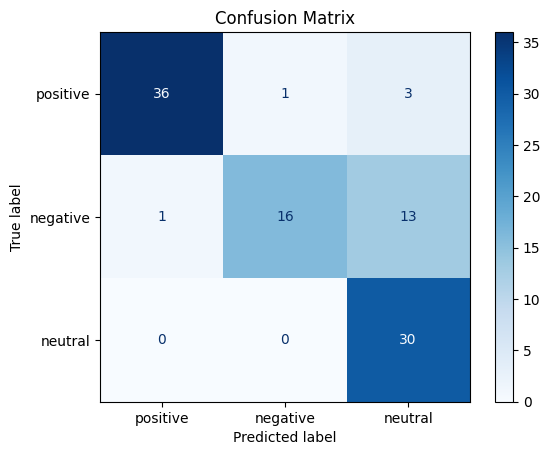

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

class_names = ['positive', 'negative', 'neutral']

preds, labels, probs = get_predictions(model_mlp, test_loader)

print("\nClassification Report:")
print(classification_report(labels, preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


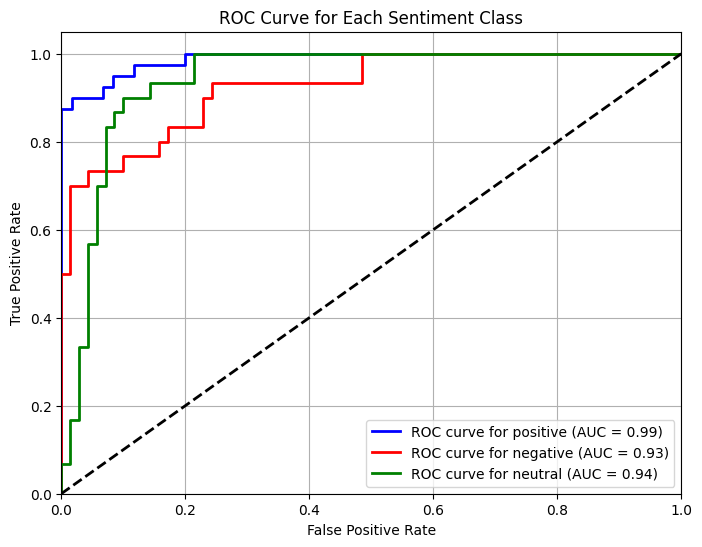

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output
labels_bin = label_binarize(labels, classes=[0, 1, 2])
n_classes = labels_bin.shape[1]

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f"ROC curve for {class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Sentiment Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [24]:
from collections import Counter
print("Test Class Distribution:", Counter(labels))


Test Class Distribution: Counter({0: 40, 1: 30, 2: 30})


In [27]:
# Set model to eval mode
model_mlp.eval()

# Get 6 random samples from the test dataset
random_samples = random.sample(list(test_loader.dataset), 6)

# Prepare the images and labels
images = torch.stack([sample[0] for sample in random_samples])
labels = torch.tensor([sample[1] for sample in random_samples])

# Move to device
images = images.to(device)
labels = labels.to(device)

# Get predictions
with torch.no_grad():
    outputs = model_mlp(images)
    probs = torch.nn.functional.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1)


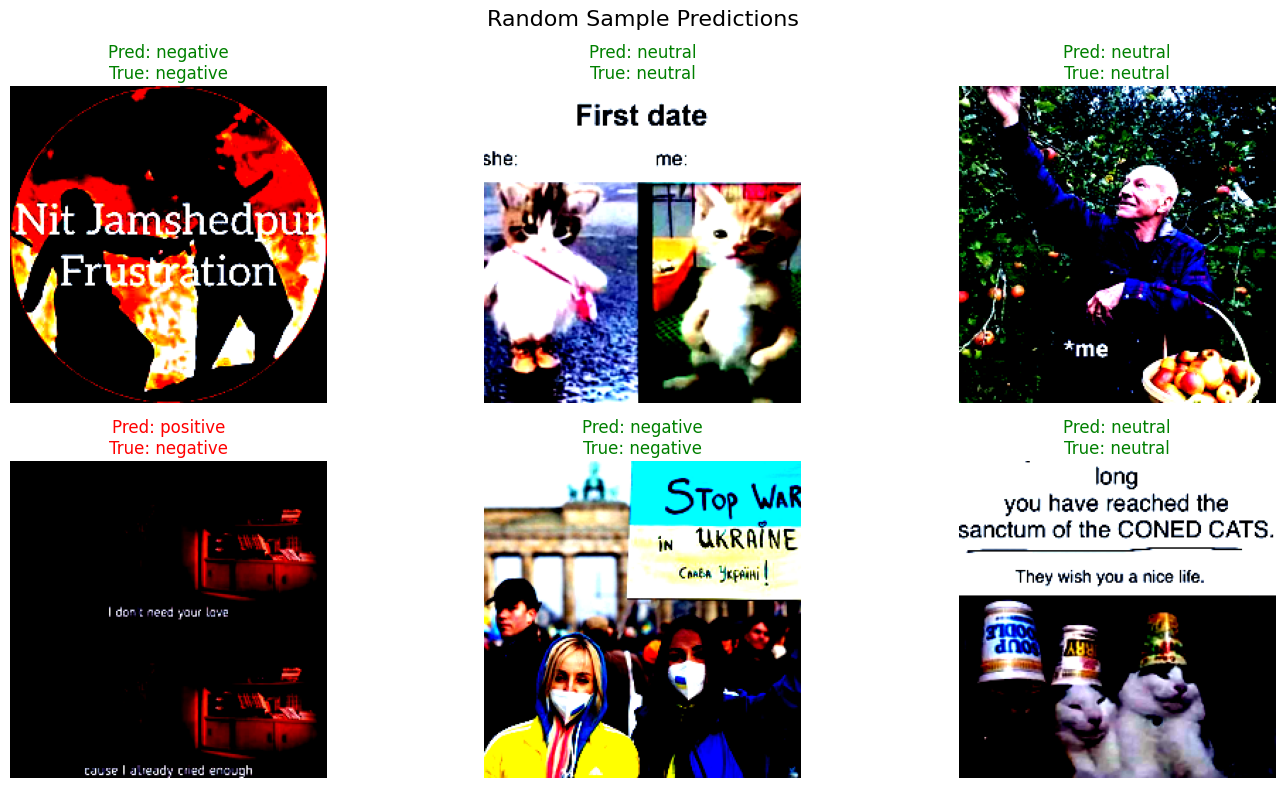

In [28]:
# Label map
class_names = ['positive', 'negative', 'neutral']

# Plot
plt.figure(figsize=(15, 8))
for i in range(len(images)):
    img_np = images[i].cpu().permute(1, 2, 0).numpy()
    img_np = np.clip(img_np, 0, 1)  # Ensure valid image range

    plt.subplot(2, 3, i + 1)
    plt.imshow(img_np)
    plt.axis("off")
    plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}",
              color='green' if preds[i] == labels[i] else 'red')
plt.suptitle("Random Sample Predictions", fontsize=16)
plt.tight_layout()
plt.show()
